# Load the Libraries

In [1]:
# Load the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.path as mpath

# Define the data source

In [2]:
# Where to load the data from
load_from_file = "Interactions PBs 2024_08_29.xlsx"
sheet = 1

# Prepare loading of the data

In [3]:
# Prepare a list of the PBs in the correct order and another list with the according colors
pbs = [
    "CC",
    "NE",
    "SO",
    "AL",
    "OA",
    "BC",
    "FW",
    "LSC",
    "BI"
]
colors = [
    "tab:red",
    "tab:orange",
    "tab:purple",
    "tab:gray",
    "tab:blue",
    "tab:olive",
    "tab:cyan",
    "tab:brown",
    "tab:green"
]


In [4]:
# A function to translate values like "high" or "medium/low" to numeric values
def get_measure(string, values=[0, 1, 2, 3]):
    numbers = []
    if not isinstance(string, str):
        return values[0]
    
    if "low" in string:
        numbers.append(values[1])
    if "medium" in string:
        numbers.append(values[2])
    if "high" in string:
        numbers.append(values[3])
        
    if len(numbers) > 0:
        return np.mean(numbers)
    else:
        return values[0]
    
# A function to translate values like "+" or "+/-" to numeric values
def get_sign(string):
    numbers = []
    if not isinstance(string, str):
        return 0
    
    if "+" in string:
        numbers.append(1)
    if "0" in string:
        numbers.append(0)
    if "-" in string:
        numbers.append(-1)
        
    if len(numbers) > 0:
        return np.mean(numbers)
    else:
        return 0
    
# Get the correct color for a connection, either by associated PB or by sign
def get_color(use_pb_colors, value):
    if use_pb_colors:
        return colors[pbs.index(value)]
    else:
        return "tab:red" if value < 0 else "tab:blue" if value > 0 else "tab:gray"


In [5]:
def prepare_data(load_from_file, filter_indirect=True, sheet=0):
    # Load data
    data = pd.read_excel(load_from_file, sheet_name=sheet)
    
    # loop through table and fill in left out PB infos
    pb = None
    for i, row in enumerate(data.iloc):
        if pd.notnull(row["Driver (PB or non-pb)"]):
            pb = row["Driver (PB or non-pb)"]
        elif pb is not None and "non-PB" not in pb:
            pb_row_index = list(data.iloc[0].index).index("Driver (PB or non-pb)")
            data.iloc[i, pb_row_index] = pb
    
    # collect the actual infos on connections
    connections = pd.DataFrame(0, index=pbs, columns=pbs)
    connections_dict = dict()
    for pb in pbs:
        connections_dict[pb] = []
        
    for row in data.iloc:
        # Find the "from" PB
        from_pb = None
        for pb in pbs:
            if f"({pb})" in row.loc["Driver (PB or non-pb)"].upper():
                from_pb = pb
                break
        # and "to" PB
        to_pb = row.loc["Affected PB"].upper().replace(" ", "")
        
        # Hide internal connections, if there are any
        if from_pb == to_pb:
            print(f"Ommitted internal connection from {from_pb} to {to_pb}")
            continue

        # Get assigned values that could be used to, e.g., scale the arrows
        relevance = row.loc["Relevance"]
        impact = row.loc["Impact strength"] if "Impact strength" in row.index else np.nan
        confidence = row.loc["Confidence"] if "Confidence" in row.index else np.nan
        sign = get_sign(row.loc["Positive/negative impact on target CV"])
        indirect = pd.notnull(row["Intermediate PB Domain"]) if "Intermediate PB Domain" in row.index else False
        indicator = row.loc["Indicator"] if "Indicator" in row.index else np.nan

        # Connections to multiple PBs are visualized as two separate connections
        if "/" in to_pb:
            print(f"Connection to multiple PBs ({to_pb}) is drawn as two separate arrows!")
        for to_single_pb in to_pb.split("/"):
            connections.loc[from_pb, to_single_pb] += 1
            connections_dict[from_pb].append(
                {
                    "to": to_single_pb, 
                    "relevance": relevance, 
                    "impact": impact, 
                    "confidence": confidence, 
                    "sign": sign,
                    "indirect": indirect,
                    "indicator": indicator
                }
            )
            
    return data, connections, connections_dict

# Actually load the data

In [6]:
data, connections, connections_dict = prepare_data(load_from_file, sheet=sheet)

Connection to multiple PBs (BI/BC) is drawn as two separate arrows!


In [7]:
data

,Driver (PB or non-pb),Affected PB,Process,Positive/negative impact on target CV,Relevance,Literature
0,Ocean Acidification (OA),BI,Increased degradation of coral reefs can lead ...,(-),medium,Hoegh-Guldberg et al. 2017; Doney et al. 2009
1,Ocean Acidification (OA),BI,increased OA can lead to a reduction in calici...,(-),medium,Doney et al. 2009; Teixidó et al. 2024
2,Ocean Acidification (OA),BI,Increased pCO2 can lead to increased photosynt...,(+),low,Das and Mangwani 2015
3,Ocean Acidification (OA),AL,Decreasing pH can increases the potential for ...,(-),low,"Das and Mangwani 2015, Deng et al. 2021, Fung ..."
4,Ocean Acidification (OA),BI/BC,OA can lead to changes in nitrification and ni...,(-/+),low,"Shi et al. 2012, Wannicke et al. 2018"
...,...,...,...,...,...,...
58,Climate Change (CC),OA,Increasing CO2 levels lead to an increased abs...,(-),high,Doney et al. 2009
59,Climate Change (CC),OA,Increasing temperatures can reduce the solubil...,(+),low,Lade et al. 2020
60,Climate Change (CC),AL,Increased droughts and changing atmospheric ci...,(-),low,Zhao et al. 2019
61,Climate Change (CC),SO,Climate change reduces stratospheric temperatu...,(+),low,Lade et al. 2019


# Define some helper functions

In [8]:
# Geometric helper functions
def length(vec):
    return np.sqrt(vec.dot(vec))

def to_xy(angle, radius):
    return np.array([radius*np.cos(np.pi/2 - angle), radius*np.sin(np.pi/2 - angle)])

def to_polar(x, y):
    return np.array((np.pi/2 - np.arctan2(y, x), length(np.array((x, y)))))

In [9]:
# A function to count the offset needed to avoid overlapping arrow ends
def count_offsets(
    connections_dict,
    from_pb, 
    to_pb,
    min_confidence=None,
    min_impact=None,
    min_relevance=None,
    use_equal_spacing=False,
    equal_spacing=1,
    width_from="relevance",
    width_scale=[0.5, 1, 2, 4],
    include_indirect=True
):
    # From and to a specific PB
    from_id = pbs.index(from_pb)
    to_id = pbs.index(to_pb)
    
    # Start at 0 offset
    from_max_offset = 0
    to_max_offset = 0
    from_offset = 0
    to_offset = 0
    
    for i, pb in enumerate(pbs):
        for con in connections_dict[pb]:
            to = pbs.index(con["to"])
            
            # only count connections that will be vissible
            if (
                get_measure(con["relevance"]) >= get_measure(min_relevance)
                and get_measure(con["confidence"]) >= get_measure(min_confidence)
                and get_measure(con["impact"]) >= get_measure(min_impact)
                and (include_indirect or not con["indirect"])
            ):
                # equal spacing or spacing according to width
                add_spacing = equal_spacing
                if not use_equal_spacing:
                    add_spacing += get_measure(con[width_from], width_scale)

                # Add spacing to both ends of the connection
                if from_id in [i, to]:
                    from_max_offset += add_spacing
                if to_id in [i, to]:
                    to_max_offset += add_spacing

                # Depending on the sorting of the PBs, count spacing of connections "before" and not "after"
                if (
                    (i == from_id and (to - i) % len(pbs) < (to_id - i) % len(pbs))
                    or (to == from_id and (i - to) % len(pbs) < (to_id - to) % len(pbs))
                ):
                    from_offset += add_spacing
                elif (
                    (i == to_id and (i - to) % len(pbs) < (i - from_id) % len(pbs))
                    or (to == to_id and (to - i) % len(pbs) < (to - from_id) % len(pbs))
                ):
                    to_offset += add_spacing

    return from_offset, to_offset, from_max_offset, to_max_offset

In [10]:
# Helper function to decide on a line style
def get_linetype(value, linetype_from="indirect"):
    if linetype_from == "indirect":
        return "dashed" if value == True else "solid"
    elif linetype_from == "sign":
        return "dashed" if value > 0 else "solid" if value < 0 else "dotted"

# Plotting functions

In [11]:
# Function to draw one connection arrow
def make_arrow(
    start_angle, 
    end_angle, 
    start_radius, 
    end_radius, 
    linetype="solid",
    width=1,
    alpha=1,
    color="k",
    arrow_head_width_factor=2,
    arrow_head_length=5,
    pb_circles=False
):
    # start and end points
    xstart, ystart = to_xy(start_angle, start_radius)
    xend, yend = to_xy(end_angle, end_radius)
    
    # define smooth curve
    curve3 = [mpath.Path.MOVETO, mpath.Path.LINETO, mpath.Path.CURVE3, mpath.Path.CURVE3]
    
    # factor by which to shorten ends
    end_factor = 0.003
    
    # calculate angle difference
    offset = end_angle - start_angle
    if offset < 0:
        offset += 2*np.pi
    offset -= np.pi

    # calculate points to construct the curve
    xmid = (xstart + xend) / 2
    ymid = (ystart + yend) / 2
    if pb_circles:
        mid = np.array([xmid, ymid]) * (np.abs(offset))**0.6 / np.pi * 1.45
    else:
        mid = np.array([xmid, ymid]) * np.abs(offset) / np.pi * 0.99
    xmid, ymid = mid
    dir1 = np.array([xmid, ymid]) - np.array([xstart, ystart])
    dir1 = dir1 / length(dir1)
    xdir1, ydir1 = dir1 * end_factor * arrow_head_length
    dir2 = np.array([xend, yend]) - np.array([xmid, ymid])
    dir2 = dir2 / length(dir2)
    xdir2, ydir2 = dir2 * end_factor * arrow_head_length

    points = [(xstart + xdir1 * 0.1 * width, ystart + ydir1 * 0.1 * width), (xstart + xdir1, ystart + ydir1), (xmid, ymid), (xend - xdir2, yend - ydir2)]

    # prepare keyword arguments for 1) the actual connection and 2) the arrow tip
    arrow1_kwargs = {
        "path": mpath.Path(points, curve3)
    }
    arrow2_kwargs = {
        "posA": (xend - xdir2 * 0.101, yend - ydir2 * 0.101),
        "posB": (xend - xdir2 * 0.1, yend - ydir2 * 0.1)
    }

    # customized line styles
    if linetype == "solid":
        linestyle = "solid"
    elif linetype == "dotted":
        linestyle = (0, (0.01, 3/np.sqrt(width)))
    elif linetype == "dashed":
        linestyle = (0, (15/np.sqrt(width), 5/np.sqrt(width)))
        
    # draw connection
    arrow1 = mpatches.FancyArrowPatch(
        arrowstyle=f"-",
        lw=width, alpha=alpha, color=color, ls=linestyle, zorder=width,
        **arrow1_kwargs
    )
    # draw arrow tip
    arrow2 = mpatches.FancyArrowPatch(
        arrowstyle=f"-|>,head_width={width*arrow_head_width_factor}, head_length={arrow_head_length}",
        lw=0, alpha=alpha, color=color, zorder=width,
        **arrow2_kwargs
    )
    return arrow1, arrow2


In [12]:
# The actual plotting function
def plot(
    connections_dict, 
    pb_circles=False,
    use_pb_colors=False,
    arrows_use_pb_colors=False,
    min_confidence=None,
    min_impact=None,
    min_relevance=None,
    include_indirect=True,
    use_equal_spacing=False,
    equal_spacing=1,
    use_broad_spacing=False,
    width_from="relevance",
    alpha_from="confidence",
    linetype_from="indirect",
    spacing_factor=0.01,
    arrow_head_width_factor=2,
    arrow_head_length=5,
    width_scale=[0.5, 1, 2, 4],
    alpha_scale=[0.25, 0.5, 0.75, 1],
    add_debug_info=False,
):
    # Set up figure
    fig = plt.figure(figsize=(10, 10))
    rect = [0, 0, 1, 1]
    ax  = fig.add_axes(rect, frameon=False)
    ax_polar = fig.add_axes(rect, polar=True, frameon=False)
    ax_polar.set_theta_offset(np.pi/2)
    ax_polar.set_theta_direction(-1)

    # Adjustments depending on if each PB is drawn as a circle or not
    if pb_circles:
        ax_polar.set_ylim(0, 1.5)
        ax.set_xlim(-1.5, 1.5)
        ax.set_ylim(-1.5, 1.5)
    else:
        ax_polar.set_ylim(0, 1.1)
        ax.set_xlim(-1.1, 1.1)
        ax.set_ylim(-1.1, 1.1)
        
    # hide grid and ticks
    for a in [ax, ax_polar]:
        a.grid(False)
        a.tick_params(
            axis="both",
            which="both",
            bottom=False,
            top=False,
            left=False,
            right=False,
            labelleft=False,
            labelbottom=False
        )
        
    
    pos_dict = dict()
    # Plot categories in a circle, with sizes according to the number of occurrences
    for i, pb in enumerate(pbs):
        pos = i/len(pbs)*2*np.pi
        pos_dict[pb] = pos
        color = colors[i] if use_pb_colors else "w"
        # Draw the PB nodes
        if pb_circles:
            # as circles
            ax_polar.scatter(pos, 0.95, color=color, edgecolor="k", lw=1, zorder=100, s=6250)
            ax_polar.text(pos, 0.95, pb, ha="center", va="center", size=12, zorder=100)
        else:
            # as segments
            ax_polar.bar(pos, 0.1, width=1/len(pbs)*2*np.pi, bottom=0.9, color=color, edgecolor="k", lw=1, zorder=100)
            ax_polar.text(pos, 0.95, pb, ha="center", va="center", size=12, zorder=100)

    # keep track of connection spacing
    keep_track = dict()
    for pb in pbs:
        keep_track[pb] = dict()
        for p in pbs:
            keep_track[pb][p] = 0
    
    # keyword arguments for counting offsets
    offset_kwargs = {
        "min_confidence": min_confidence,
        "min_impact": min_impact,
        "min_relevance": min_relevance,
        "use_equal_spacing": use_equal_spacing,
        "equal_spacing": equal_spacing,
        "width_from": width_from,
        "width_scale": width_scale,
        "include_indirect": include_indirect
    }

    # Loop over PBs
    for i in range(len(pbs)):
        pb = pbs[i]
        # Loop over connections
        for con in connections_dict[pb]:
            # Only draw if the requirements are met
            if (
                get_measure(con["relevance"]) >= get_measure(min_relevance)
                and get_measure(con["confidence"]) >= get_measure(min_confidence)
                and get_measure(con["impact"]) >= get_measure(min_impact)
                and (include_indirect or not con["indirect"])
            ):
                # keep track of spacing
                add_to_spacing = (
                    (get_measure(con[width_from], width_scale) + equal_spacing) 
                    if not use_equal_spacing else equal_spacing
                ) / 2
                
                # add spacing before
                keep_track[pb][con["to"]] += add_to_spacing
                
                # get offset
                from_offset, to_offset, from_max_offset, to_max_offset = count_offsets(
                    connections_dict, 
                    pb, 
                    con["to"],
                    **offset_kwargs
                )
                # adjust both ends of connection
                from_offset += keep_track[pb][con["to"]]
                to_offset += keep_track[pb][con["to"]]
                
                # rescale offset by a factor
                from_offset_scaled = (from_max_offset/2 - from_offset) * spacing_factor
                to_offset_scaled = (to_offset - to_max_offset/2) * spacing_factor
                
                # optional broad spacing
                if use_broad_spacing:
                    from_offset_scaled = from_offset_scaled / from_max_offset * 70
                    to_offset_scaled = to_offset_scaled / to_max_offset * 70
                
                # calculate radii and angles with offsets
                if pb_circles:
                    start_angle = pos_dict[pb]
                    end_angle = pos_dict[con["to"]]
                                                            
                    start_x, start_y = to_xy(start_angle, 1.05) - to_xy(start_angle - from_offset_scaled * 4, 0.275)
                    end_x, end_y = to_xy(end_angle, 1.05) - to_xy(end_angle - to_offset_scaled * 4, 0.275)
                    
                    start_angle, start_radius = to_polar(start_x, start_y)
                    end_angle, end_radius = to_polar(end_x, end_y)
                else:
                    start_angle = pos_dict[pb] + from_offset_scaled
                    end_angle = pos_dict[con["to"]] + to_offset_scaled
                    start_radius = 0.9
                    end_radius = 0.9
                
                # plot the connection arrow
                color = get_color(True, pb) if arrows_use_pb_colors else get_color(False, con["sign"])
                arrow1, arrow2 = make_arrow(
                    start_angle, 
                    end_angle, 
                    start_radius, 
                    end_radius, 
                    width=get_measure(con[width_from], width_scale),
                    alpha=(get_measure(con[alpha_from], alpha_scale) if alpha_from is not None else 1),
                    color=color,
                    arrow_head_width_factor=arrow_head_width_factor,
                    arrow_head_length=arrow_head_length,
                    linetype=get_linetype(con["indirect"] if linetype_from == "indirect" else con["sign"], linetype_from),
                    pb_circles=pb_circles
                )
                ax.add_patch(arrow1)
                ax.add_patch(arrow2)
                
                # add spacing after
                keep_track[pb][con["to"]] += add_to_spacing
                        
    # add information about what is actually plotted to the plot
    if add_debug_info:
        debug_info = f"line width = {width_from}\n"
        if alpha_from is not None:
            debug_info += f"line alpha = {alpha_from}\n"
        debug_info += f"line color = {'PB' if arrows_use_pb_colors else 'sign of link'}\n"
        if linetype_from == "sign":
            debug_info += f"(solid/dotted/dashed) lines = (-/0/+)\n"
        debug_info += f"indirect links are {('dashed' if linetype_from == 'indirect' else 'included') if include_indirect else 'omitted'}\n"
        debug_info += f"min. impact = {min_impact}\n"
        debug_info += f"min. confidence = {min_confidence}\n"
        debug_info += f"min. relevance = {min_relevance}\n"
        ax.text(0.7, -1.1, debug_info)

# Plotting

C:\Users\jonask\AppData\Local\Temp\ipykernel_22344\1968976313.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


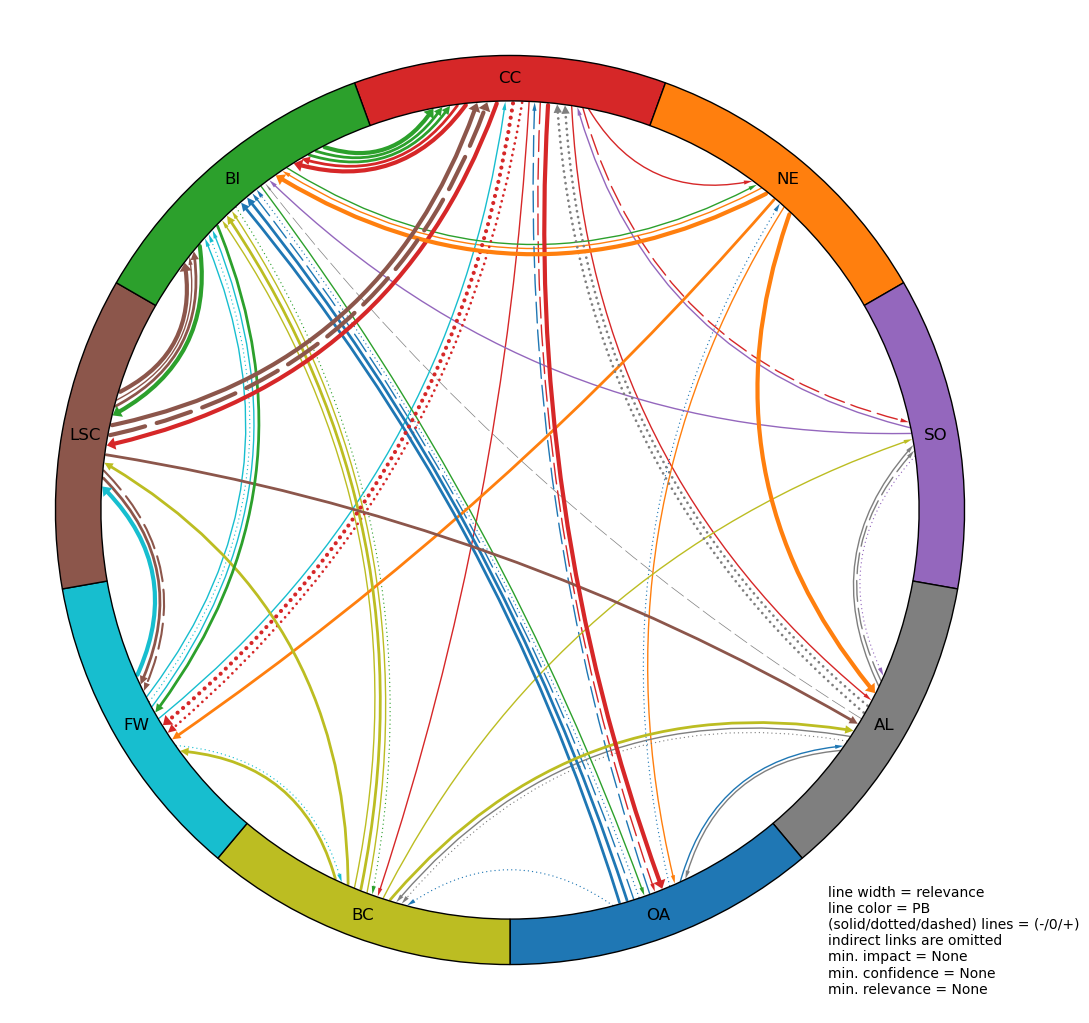

In [13]:
# Plot the data in the way that is in the report figure
plot(
    connections_dict, 
    pb_circles=False,
    use_pb_colors=True,
    arrows_use_pb_colors=True,
    min_confidence=None,
    min_impact=None,
    min_relevance=None,
    include_indirect=False,
    use_equal_spacing=False,
    use_broad_spacing=False,
    equal_spacing=1.5,
    width_from="relevance",
    alpha_from=None,
    linetype_from="sign",
    spacing_factor=0.0055,
    arrow_head_width_factor=1.5,
    arrow_head_length=6,
    width_scale=[0.5, 1, 2, 3],
    alpha_scale=[0.25, 0.5, 0.75, 1],
    add_debug_info=True
)

# Save to file
folder = "export/"
name = "pb_interconnections"
plt.tight_layout()
plt.savefig(folder + name + ".png", bbox_inches="tight")
plt.savefig(folder + name + ".svg")

C:\Users\jonask\AppData\Local\Temp\ipykernel_22344\4191863329.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


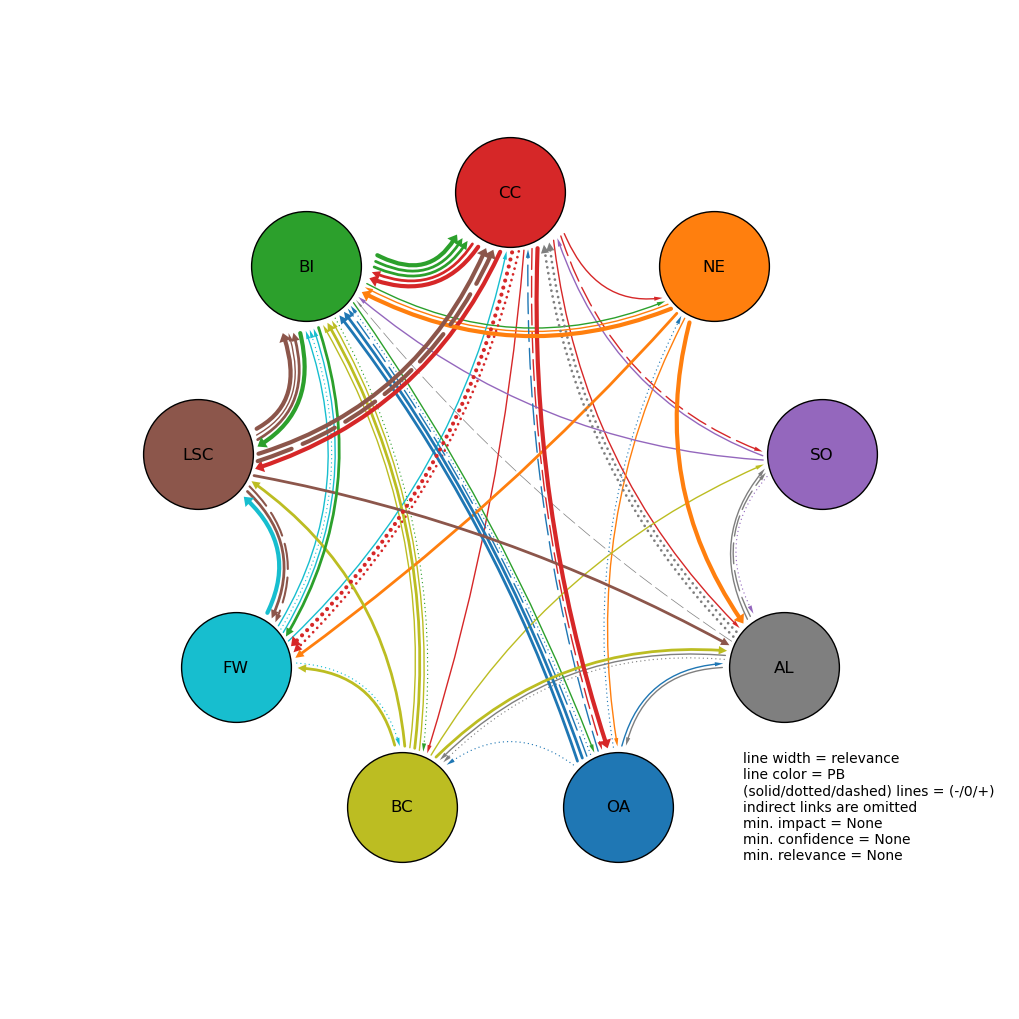

In [14]:
# Plot the data in another alternative way
plot(
    connections_dict, 
    pb_circles=True,
    use_pb_colors=True,
    arrows_use_pb_colors=True,
    min_confidence=None,
    min_impact=None,
    min_relevance=None,
    include_indirect=False,
    use_equal_spacing=False,
    use_broad_spacing=False,
    equal_spacing=1.5,
    width_from="relevance",
    alpha_from=None,
    linetype_from="sign",
    spacing_factor=0.0045,
    arrow_head_width_factor=1.5,
    arrow_head_length=6,
    width_scale=[0.5, 1, 2, 3],
    alpha_scale=[0.25, 0.5, 0.75, 1],
    add_debug_info=True
)

# Save to file
folder = "export/"
name = "pb_interconnections_alternative"
plt.tight_layout()
plt.savefig(folder + name + ".png", bbox_inches="tight")
plt.savefig(folder + name + ".svg")